In [1]:
# WEEDMAPS DATA CLEANING: BUSINESS-LEVEL DATA
# - create indicators for whether we have medical / recreational license info
# - create indicators for descriptors (e.g. in-store purchases only, order online, medical and recreational etc)
# - create variable for state that dispensary is located in
# - split license variable into medical and recreational licenses (INCOMPLETE)


# Imports
import pandas as pd
import os
import re
from pyzipcode import ZipCodeDatabase


In [2]:
zcdb = ZipCodeDatabase()

In [3]:
# Import business-level data
df = pd.read_csv("../stores_data.csv")

Create indicators for medical / recreational license


In [4]:
cats = ["Medical", "Adult-Use"]
for cat in cats:
    df[cat + "_ID?"] = df["Licenses"].str.contains(cat, case = False).astype(float)

Create indicator variables based on descriptors

In [5]:
df2 = df.copy()
df2["Descriptors"] = df2.apply(lambda row : "|".join([x.strip() for x in row["Descriptors"].split("|")]),
                             axis = 1)

In [6]:
df_desc2 = df2.Descriptors.str.get_dummies()

In [7]:
df3 = df2.join(df_desc2)

Create state variable

In [8]:
states =["Alabama", "Alaska", "Arizona", "Arkansas", "California", 
             "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", 
             "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", 
             "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", 
             "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", 
             "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", 
             "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", 
             "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", 
             "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", 
             "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

# function to check which state a dispensary is in
def get_state(col_val):
    col_val = col_val.split(",")[-1]
    state_val = None
    for state in states:
        st = state.lower() + " "
        if st in col_val.lower():
            state_val = state
            break
    return state_val

In [9]:
# applying function to dataframe
df4 = df3.copy()
df4["State"] = df4.apply(lambda row : get_state(row["Address"]),
                             axis = 1)

In [10]:
# businesses with 2 potential state names in their address (currently 167)
dftest = df4[~df4.State.isna()]
df_amb = dftest[dftest.State.map(len) > 1]
len(df_amb)

5217

In [11]:
# businesses which are likely not based in any of the 50 US states (currently 1480)
df_no_state = df4[df4["State"].isna()]
len(df_no_state)

1484

In [12]:
# testing
test = df.Descriptors[0]
test2 = df2.Descriptors[0]
test2
test

'Dispensary | Order online | Recreational | Supports the Black community'

In [13]:
test = df.Address[0]
test

'436 N Clark Street, Chicago, Illinois 60654'

In [14]:
# CREATE INDICATORS BASED ON DESCRIPTORS
# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer()

# df_desc = pd.DataFrame(cv.fit_transform(df.Descriptors.fillna('').str.replace(r"\|", " ")).A,
#                        columns=cv.get_feature_names_out(),
#                        index = df.index)

In [15]:
df4['Medical Store?'] = df4[['Medical', 'Medical & Recreational', 'Medicinal & Recreational']].apply(lambda s : s > 0).any(axis = 1)
df4['Recreational Store?'] = df4[['Recreational', 'Medical & Recreational', 'Medicinal & Recreational']].apply(lambda s : s > 0).any(axis = 1)
df4 = df4.drop(['Medical', 'Recreational', 'Medical & Recreational', 'Medicinal & Recreational', 'Descriptors'], axis = 1).rename({"Name" : "Store Name"}, axis = 1)

In [18]:
df4.drop("Url", axis = 1).to_csv("../stores_data_clean.csv")

In [19]:
import pandas as pd
products = pd.concat([pd.read_csv(f"../products_data_cleaned/part_{i}.csv") for i in range(1, 11)]).drop_duplicates().reset_index(drop = True)
products = products.merge(df4, left_on='url', right_on = "Url", how = 'inner').query("State == State").reset_index(drop = True)

In [23]:
output_directory = 'products_data_final/'
os.mkdir(output_directory)

# Calculate the number of rows per part
num_rows = len(products)
rows_per_part = num_rows // 10

# Split the CSV into 10 parts
for i in range(10):
    start_idx = i * rows_per_part
    end_idx = start_idx + rows_per_part
    if i == 9:
        end_idx = num_rows
    part_df = products.drop("Url", axis = 1).iloc[start_idx:end_idx]
    
    # Save each part to a separate CSV file
    output_file = os.path.join(output_directory, f'part_{i+1}.csv')
    part_df.to_csv(output_file, index=False)

In [19]:
#products[products['thc'].str.contains("mg")]
test = products.query("thc != 'None' & price != 'None' & weight != 'None'")
test = test[test['thc'].str.contains("%")]
test['thc'] = test['thc'].apply(lambda s : float(re.search("\d*\.?\d+", s).group()))
test['weight'] = test['weight'].apply(lambda s : float(re.search("\d*\.?\d+", s).group()))
test['thc'] = test['thc'] * test['weight'] / 100
test['price'] = test['price'].apply(lambda s : float(s[1:]))

In [53]:
legalization = pd.read_csv("../legalization_data.txt").set_index("state").drop(['DC', 'Virginia', 'Delaware', 'Minnesota', 'Ohio'])
legalization.loc['Nevada', "tax_rate"] = "15%"
legalization["legalization_date"] = legalization['legalization_date'].astype('datetime64[m]')
legalization["licensed_sales_since_date"] = legalization['licensed_sales_since_date'].astype('datetime64[m]')
#legalization['tax_rate'] = legalization['tax_rate'].apply(lambda s : float(s[:-1]))
legalization

,legalization_date,licensed_sales_since_date,tax_rate
state,,,
Washington,2012-12-06,2014-07-08,37%
Colorado,2012-12-10,2014-01-01,15%
Alaska,2015-02-24,2016-10-29,$50/ounce
Oregon,2015-07-01,2015-10-01,17%
California,2016-11-09,2018-01-01,15%
Massachusetts,2016-12-15,2018-11-20,10.75%
Nevada,2017-01-01,2017-07-01,15%
Maine,2017-01-30,2020-10-09,10%
Vermont,2018-07-01,2022-10-01,14%


Linear Model: Slope : [0.02245506], Intercept : 9.093980437759559 R^2 : 0.6674123280969375


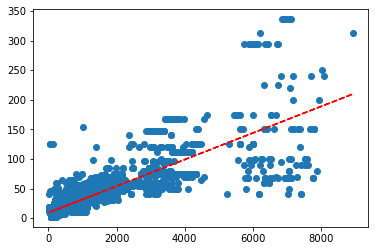

In [235]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

test2 = test.query(f"category == 'FLOWER' & State == 'New Mexico' & thc < 15000")
data = test2[['thc', 'price']].to_numpy()
data_x = data[:, 0]
data_y = data[:, 1]
model = LinearRegression().fit(data_x.reshape((-1, 1)), data_y)
print(f"Linear Model: Slope : {model.coef_}, Intercept : {model.intercept_} R^2 : {model.score(data_x.reshape((-1, 1)), data_y)}")
plt.scatter(data_x ,data_y)
plt.plot(data_x, model.intercept_ + model.coef_ * data_x, 'r--')
plt.show()

In [229]:
results = []
for state in legalization.index:
    data = test.query(f"category == 'FLOWER' & State == '{state}' & price < 500 & thc < 15000")[['thc', 'price']].to_numpy()
    data_x = data[:, 0]
    data_y = data[:, 1]
    model = LinearRegression().fit(data_x.reshape((-1, 1)), data_y)
    results.append({"Number of Data Points" : data_x.shape[0], "state" : state, "intercept" : model.intercept_, "slope" : model.coef_[0], "R^2" : model.score(data_x.reshape((-1, 1)), data_y)})

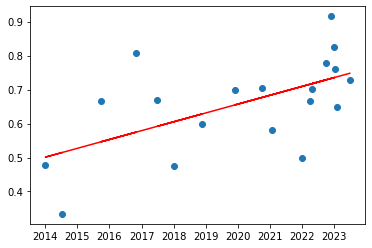

0.33422242279726666


In [230]:
results_df = pd.DataFrame(results).set_index("state").join(legalization)
results_df_tax = results_df.drop(['Alaska', 'Illinois', 'Connecticut', 'New Jersey', 'Maryland'])
results_df_tax['tax_rate'] = results_df_tax['tax_rate'].apply(lambda s : float(s[:-1]))

data_x = results_df['licensed_sales_since_date'].astype("int64").to_numpy().reshape((-1, 1))
model2 = LinearRegression().fit(data_x, results_df['R^2'])
plt.scatter(results_df['licensed_sales_since_date'], results_df['R^2'])
plt.plot(results_df['licensed_sales_since_date'], model2.predict(data_x), 'r')
plt.show()
print(model2.score(data_x, results_df['R^2']))

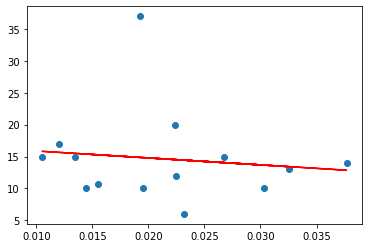

0.014696384620309422


In [246]:
data_x = results_df_tax['slope'].astype("float64").to_numpy().reshape((-1, 1))
model2 = LinearRegression().fit(data_x, results_df_tax['tax_rate'])
plt.scatter(data_x, results_df_tax['tax_rate'])
plt.plot(data_x, model2.predict(data_x), 'r')
plt.show()
print(model2.score(data_x, results_df_tax['tax_rate']))

,category,name,thc,cbd,price,weight,url,Name,Number Reviews,Avg Rating,...,Adult-Use_ID?,Dispensary,In-store purchases only,Medical,Medical & Recreational,Medicinal & Recreational,Order online,Recreational,Supports the Black community,State
825769,FLOWER,14g Wedding Pie,2646.0,0.1% CBD,120.0,14000.0,https://weedmaps.com/dispensaries/munchiez-can...,MUNCHIEZ CANNABIS,111 reviews,5.0,...,1.0,1,0,0,1,0,1,0,0,New Mexico


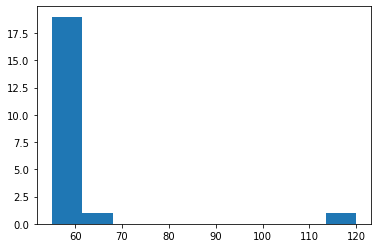

In [244]:
slice = 2500
plt.hist(test2[(slice <= test2['thc']) & (test2['thc'] < slice + 200)]['price'])
test2[(slice <= test2['thc']) & (test2['thc'] < slice + 200) & (test2['price'] > 100)]

# # with new mexico:
# slice = 2500
# plt.hist(test2[(slice <= test2['thc']) & (test2['thc'] < slice + 200)]['price'])
# test2[(slice <= test2['thc']) & (test2['thc'] < slice + 200) & (test2['price'] < 100)]

Linear Model: Slope : [0.02666448], Intercept : 32.14261097207495 R^2 : 0.6834872071439736


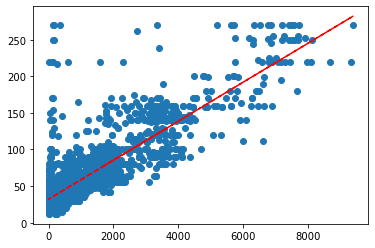

In [245]:
test3 = test.query(f"category == 'FLOWER' & State == 'Illinois' & thc < 15000")[['name', 'thc', 'price']].groupby("name").mean()
data = test3.to_numpy()
data_x = data[:, 0]
data_y = data[:, 1]
model = LinearRegression().fit(data_x.reshape((-1, 1)), data_y)
print(f"Linear Model: Slope : {model.coef_}, Intercept : {model.intercept_} R^2 : {model.score(data_x.reshape((-1, 1)), data_y)}")
plt.scatter(data_x ,data_y)
plt.plot(data_x, model.intercept_ + model.coef_ * data_x, 'r--')
plt.show()

,thc,price
name,,
Cresco Face Mints Popcorn Flower,123.200000,153.333333
Cresco Girls best Friend Popcorn Flower,142.800000,270.000000
Good Green Glue Tang Haze Mixed Buds Flower,157.500000,130.000000
Good Green Sunset Sherbet Popcorn Flower,101.850000,120.000000
High Supply Apple Fritter Popcorn Flower,254.333333,216.666667
High Supply Gas Station Sushi Popcorn Flower,173.600000,270.000000
High Supply Gelato Popcorn,123.200000,220.000000
High Supply Hybrid Popcorn 28g - Space Daddy,154.000000,250.000000
High Supply Jealousy Popcorn Flower,127.400000,140.000000


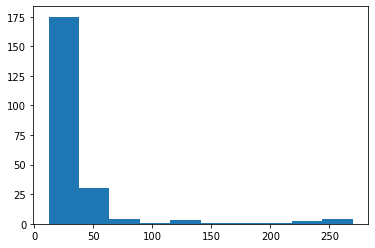

In [195]:
#with illinois
slice = 100
plt.hist(test3[(slice <= test3['thc']) & (test3['thc'] < slice + 200)]['price'])
test3[(slice <= test3['thc']) & (test3['thc'] < slice + 200) & (test3['price'] > 100)]


In [212]:
results = []
for state in legalization.index:
    data = test.query(f"category == 'FLOWER' & State == '{state}' & thc < 15000 & price < 500")[['name', 'thc', 'price']].groupby("name").mean().to_numpy()
    data_x = data[:, 0]
    data_y = data[:, 1]
    model = LinearRegression().fit(data_x.reshape((-1, 1)), data_y)
    results.append({"Number of Data Points" : data_x.shape[0], "state" : state, "intercept" : model.intercept_, "slope" : model.coef_[0], "R^2" : model.score(data_x.reshape((-1, 1)), data_y)})

(array([580.,  18.,  14.,  12.,   2.,   6.,   0.,   3.,   0.,   1.]),
 array([  4. ,  37.2,  70.4, 103.6, 136.8, 170. , 203.2, 236.4, 269.6,
        302.8, 336. ]),
 <BarContainer object of 10 artists>)

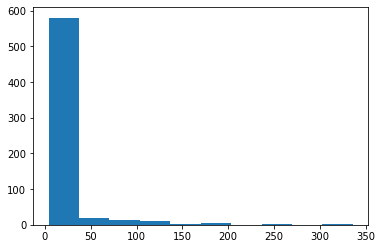

In [ ]:
data = test.query("category == 'FLOWER' & State == 'Washington'")[['thc', 'price']].query("200 < thc & thc < 250").to_numpy()
data_x = data[:, 0]
data_y = data[:, 1]
plt.hist(data_y)

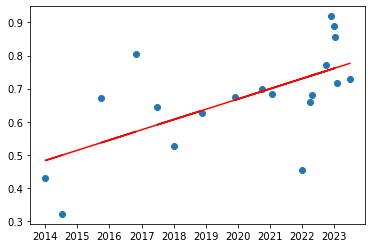

0.3957121087569757


In [220]:
results_df = pd.DataFrame(results).set_index("state").join(legalization)
results_df_tax = results_df.drop(['Alaska', 'Illinois', 'Connecticut', 'New Jersey', 'Maryland'])
results_df_tax['tax_rate'] = results_df_tax['tax_rate'].apply(lambda s : float(s[:-1]))

data_x = results_df['licensed_sales_since_date'].astype("int64").to_numpy().reshape((-1, 1))
model2 = LinearRegression().fit(data_x, results_df['R^2'])
plt.scatter(results_df['licensed_sales_since_date'], results_df['R^2'])
plt.plot(results_df['licensed_sales_since_date'], model2.predict(data_x), 'r')
plt.show()
print(model2.score(data_x, results_df['R^2']))

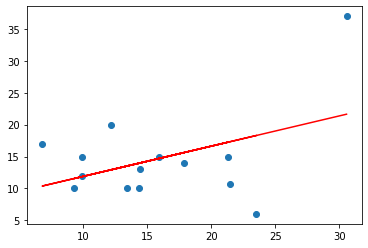

0.17975938282640103


In [227]:
data_x = results_df_tax['intercept'].astype("float64").to_numpy().reshape((-1, 1))
model2 = LinearRegression().fit(data_x, results_df_tax['tax_rate'])
plt.scatter(data_x, results_df_tax['tax_rate'])
plt.plot(data_x, model2.predict(data_x), 'r')
plt.show()
print(model2.score(data_x, results_df_tax['tax_rate']))

C:\Users\kdugg\AppData\Local\Temp\ipykernel_9896\4110388632.py:50: RuntimeWarning: invalid value encountered in true_divide
  pi/=np.tile(np.sum(pi,1),(2,1)).T


ValueError: array must not contain infs or NaNs

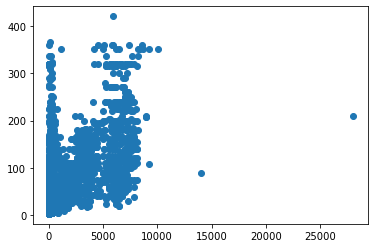

In [ ]:
import numpy as np
import scipy.linalg as lin

test2 = test.query(f"category == 'FLOWER' & State == 'Washington' & thc > 0")
data = test2[['thc', 'price']].query("thc < 28000").to_numpy()
data_x = data[:, 0]
data_y = data[:, 1]
N = len(data_x)
x = np.concatenate((data_x.reshape((N, 1)), np.ones((N, 1))), axis = 1)
y = data_y

rx=np.ones( (100,2) )
r=np.arange(0,1,.01)
rx[:,0]=r

#plot the random dataset
plt.scatter(data_x, data_y)

# regularization parameter for the regression weights
lam=.01

def em():
    # mixture weights
    rpi=np.zeros( (2) )+.5

    # expected mixture weights for each data point
    pi=np.zeros( (len(x),2) )+.5

    #the regression weights
    w1=np.random.rand(2)
    w2=np.random.rand(2)

    #precision term for the probability of the data under the regression function 
    eta=100

    for _ in range(100):
        if 0:
            plt.plot(r,np.dot(rx,w1),'-r',alpha=.5)
            plt.plot(r,np.dot(rx,w2),'-g',alpha=.5)

        #compute lhood for each data point
        err1=y-np.dot(x,w1)
        err2=y-np.dot(x,w2)
        prbs=np.zeros( (len(y),2) )
        prbs[:,0]=-.5*eta*err1**2
        prbs[:,1]=-.5*eta*err2**2

        #compute expected mixture weights
        pi=np.tile(rpi,(len(x),1))*np.exp(prbs)
        pi/=np.tile(np.sum(pi,1),(2,1)).T

        #max with respect to the mixture probabilities
        rpi=np.sum(pi,0)
        rpi/=np.sum(rpi)

        #max with respect to the regression weights
        pi1x=np.tile(pi[:,0],(2,1)).T*x
        xp1=np.dot(pi1x.T,x)+np.eye(2)*lam/eta
        yp1=np.dot(pi1x.T,y)
        w1=lin.solve(xp1,yp1)

        pi2x=np.tile(pi[:,1],(2,1)).T*x
        xp2=np.dot(pi2x.T,x)+np.eye(2)*lam/eta
        yp2=np.dot(pi[:,1]*y,x)
        w2=lin.solve(xp2,yp2)

        #max wrt the precision term
        eta=np.sum(pi)/np.sum(-prbs/eta*pi)

        #objective function - unstable as the pi's become concentrated on a single component
        obj=np.sum(prbs*pi)-np.sum(pi[pi>1e-50]*np.log(pi[pi>1e-50]))+np.sum(pi*np.log(np.tile(rpi,(len(x),1))))+np.log(eta)*np.sum(pi)
        print (obj,eta,rpi,w1,w2)

        try:
            if np.isnan(obj): break
            if np.abs(obj-oldobj)<1e-2: break
        except:
            pass

        oldobj=obj

    return w1,w2


#run the em algorithm and plot the solution
rw1,rw2=em()
plt.plot(r,np.dot(rx,rw1),'-r')
plt.plot(r,np.dot(rx,rw2),'-g')

plt.show()